In [1]:
# colab only
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
import cv2
import numpy as np
from enum import Enum
import tensorflow as tf
from random import sample
import matplotlib.pyplot as plt
from tensorflow.image import resize, ResizeMethod
from tensorflow.keras import Model, layers, initializers, Input
from tensorflow.keras.applications import VGG16, ResNet50, vgg16, resnet50
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Lambda, Resizing
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
class DNN(Enum):
  VGG16 = 'vgg16'
  RESNET50 = 'resnet50'

# Data generator for your own training

In [30]:
MAP_WIDTH = 20
MAP_HEIGHT = 15
TRAIN_IMG_PATH = '/content/gdrive/MyDrive/salicon/images/train'
TRAIN_MAP_PATH = '/content/gdrive/MyDrive/salicon/maps/train'
VAL_IMG_PATH = '/content/gdrive/MyDrive/salicon/images/val'
VAL_MAP_PATH = '/content/gdrive/MyDrive/salicon/maps/val'
TEST_IMG_PATH = '/content/gdrive/MyDrive/salicon/images/test'
BATCH = 10

class CustomDataGenerator(Sequence):
    def __init__(self, data, labels, batch_size, max_size = 1000, dnn = DNN.VGG16):
      self.batch_size = batch_size
      self.images = [data + "/" + f for f in sorted(os.listdir(data))[:max_size]]
      self.maps = [labels + "/" + f for f in sorted(os.listdir(labels))[:max_size]]
      self.preprocess_input = vgg16.preprocess_input if dnn == DNN.VGG16 else  resnet50.preprocess_input

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        x = []
        y = []
        for f in self.images[start:end]:
          image = cv2.imread(f)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          image = self.preprocess_input(image)

          x.append(image)

        for f in self.maps[start:end]:
          image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
          image = cv2.resize(image, (MAP_WIDTH, MAP_HEIGHT), interpolation=cv2.INTER_NEAREST)
          y.append(image.astype('float32') / 255)

        return np.array(x), np.array(y)

train_generator = CustomDataGenerator(TRAIN_IMG_PATH, TRAIN_MAP_PATH, BATCH, 10000)
validation_generator = CustomDataGenerator(VAL_IMG_PATH, VAL_MAP_PATH, BATCH, 5000)

# Simple Saliency model based on SALICON

In [5]:
MODELS_PATH='/content/gdrive/MyDrive/'

class SimpleSaliency(Model):
    def __init__(self, name='saliency', dnn = DNN.VGG16, load_weights = True, **kwargs):
      self.dnn = dnn
      super().__init__(name=name, **kwargs)
      self.build((None, 480, 640, 3)) # SALICON dataset shape
      if load_weights:
        if len(MODELS_PATH) == 0:
          raise Exception('Set value for global variable MODELS_PATH')

        if self.dnn == DNN.VGG16: # load weights
          self.load_weights(f'{MODELS_PATH}/vgg16/simple_saliency_vgg16.tf')
        else:
          self.load_weights(f'{MODELS_PATH}/resnet50/simple_saliency_resnet50.tf')
      self.preprocess_input = vgg16.preprocess_input if dnn == DNN.VGG16 else  resnet50.preprocess_input

    def __build_vgg16(self, input_shape, stream_type):
      vgg = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
      for layer in vgg.layers:
        layer._name = layer._name + '_' + stream_type
        layer.trainable = True
      vgg.trainable = True

      return vgg

    def __build_resnet50(self, input_shape, stream_type):
      resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
      for layer in resnet50.layers:
        layer._name = layer._name + '_' + stream_type
        layer.trainable = True
      resnet50.trainable = True

      return resnet50

    def __build_dnn(self, input_shape, stream_type):
      if self.dnn == DNN.VGG16:
        return self.__build_vgg16(input_shape, stream_type)
      else:
        return self.__build_resnet50(input_shape, stream_type)

    def build(self, input_shape):
      H, W = input_shape[1:3]
      self.fine = self.__build_dnn(input_shape=(H, W, 3), stream_type='fine')
      self.downscale_input = MaxPooling2D(pool_size=(2, 2))
      self.coarse = self.__build_dnn(input_shape=(H // 2, W // 2, 3), stream_type='coarse')
      self.saliency_map_layer = Conv2D(
        1, (1, 1),
        name='saliency_map',
        trainable=True,
        activation='sigmoid',
        kernel_initializer=initializers.Zeros(),
        bias_initializer=initializers.Zeros()
      )
      super().build(input_shape)

    def call(self, input):
      # create two streams separately
      fine_output = self.fine(input)

      downscaled_input = self.downscale_input(input)
      coarse_output = self.coarse(downscaled_input)

      # add interpolation layer to the coarse stream
      H, W = self.fine.output.shape[1:3]

      interp_layer = Resizing(H, W, interpolation='nearest')(coarse_output)

      concat_layer = concatenate([fine_output, interp_layer], axis=-1)

      return self.saliency_map_layer(concat_layer)

    def compute_saliency(self, img_path):
      image = cv2.imread(img_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (640, 480))
      image = self.preprocess_input(image)
      h, w = image.shape[:2]

      smap = np.squeeze(self.predict(np.expand_dims(image, axis=0), batch_size=1, verbose=0))

      smap = (smap - np.min(smap))/((np.max(smap)-np.min(smap)))
      smap = cv2.resize(smap, (w, h), interpolation=cv2.INTER_CUBIC)
      smap = cv2.GaussianBlur(smap, (75, 75), 25, cv2.BORDER_DEFAULT)

      return smap

model = SimpleSaliency(dnn=DNN.RESNET50)
model.summary()

Model: "saliency"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 15, 20, 2048)      23587712  
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 resnet50 (Functional)       (None, 8, 10, 2048)       23587712  
                                                                 
 saliency_map (Conv2D)       multiple                  4097      
                                                                 
Total params: 47179521 (179.98 MB)
Trainable params: 47073281 (179.57 MB)
Non-trainable params: 106240 (415.00 KB)
_________________________________________________________________


# Some examples of model predictions

In [33]:
# Helper function for showing results
def show_image(image_path, predicted, saliency_map_path = None):
    image = plt.imread(image_path)

    fig, axes = plt.subplots(1, 3 if saliency_map_path is not None else 2, figsize=(8, 4))

    axes[0].imshow(image)
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(predicted, cmap='gray')
    axes[1].set_title('Predicted')
    axes[1].axis('off')

    if saliency_map_path:
      saliency_map = plt.imread(saliency_map_path)
      axes[2].imshow(saliency_map, cmap='gray')
      axes[2].set_title('Ground truth')
      axes[2].axis('off')

    plt.show()

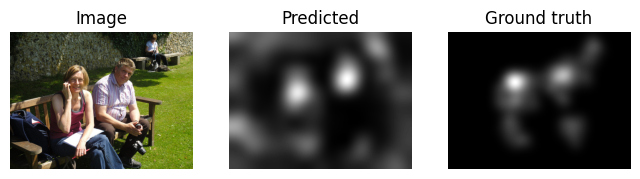

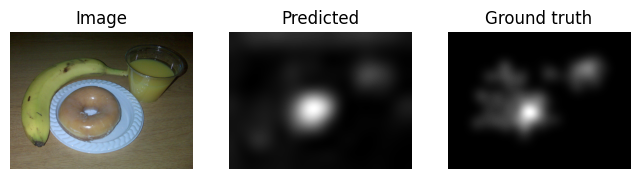

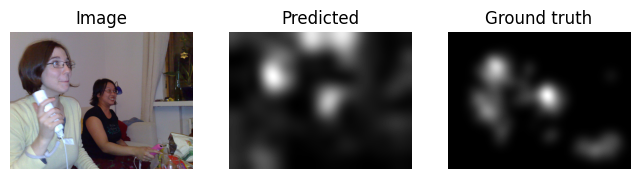

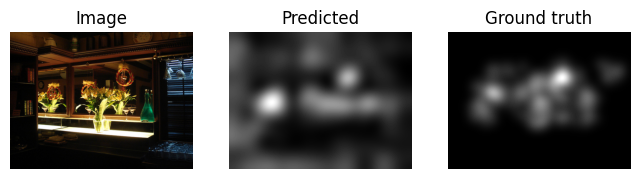

In [34]:
imgs = [f.replace('.jpg', '') for f in sample(os.listdir(VAL_IMG_PATH), 4)]
for img in imgs:
  show_image(
    f'/content/gdrive/MyDrive/salicon/images/val/{img}.jpg',
    model.compute_saliency(f'/content/gdrive/MyDrive/salicon/images/val/{img}.jpg'),
    f'/content/gdrive/MyDrive/salicon/maps/val/{img}.png'
  )

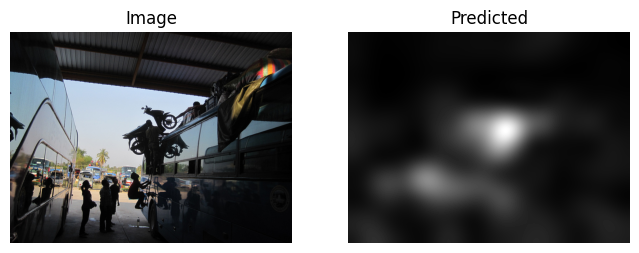

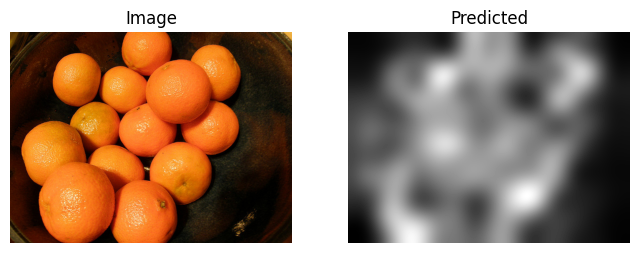

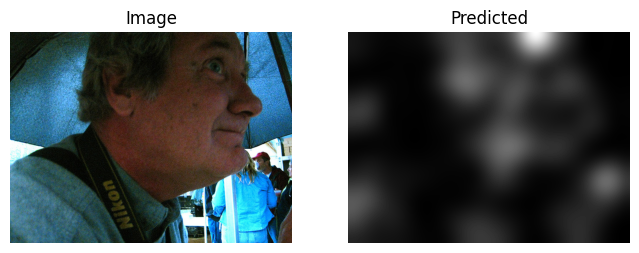

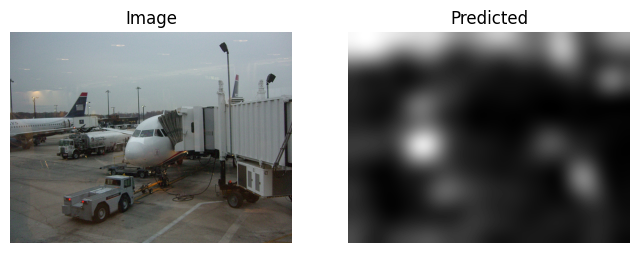

In [35]:
imgs = [f.replace('.jpg', '') for f in sample(os.listdir(TEST_IMG_PATH), 4)]
for img in imgs:
  show_image(
    f'/content/gdrive/MyDrive/salicon/images/test/{img}.jpg',
    model.compute_saliency(f'/content/gdrive/MyDrive/salicon/images/test/{img}.jpg')
  )